In [3]:
# !pip install torch
# !pip install torchvision==0.19.1
# !pip install torchsummary==1.5.1
# !pip install pandas==2.2.3
# !pip install scikit-learn==1.5.2
# !pip install matplotlib==3.9.2
# !pip install seaborn==0.13.2
# !pip install tqdm==4.66.5
# !pip install jupyterlab==4.0.9
# !pip install jupyter==1.0.0
# !pip install ipywidgets==8.1.1

# Data exploration

Number of images: 39209
Number of classes: 43


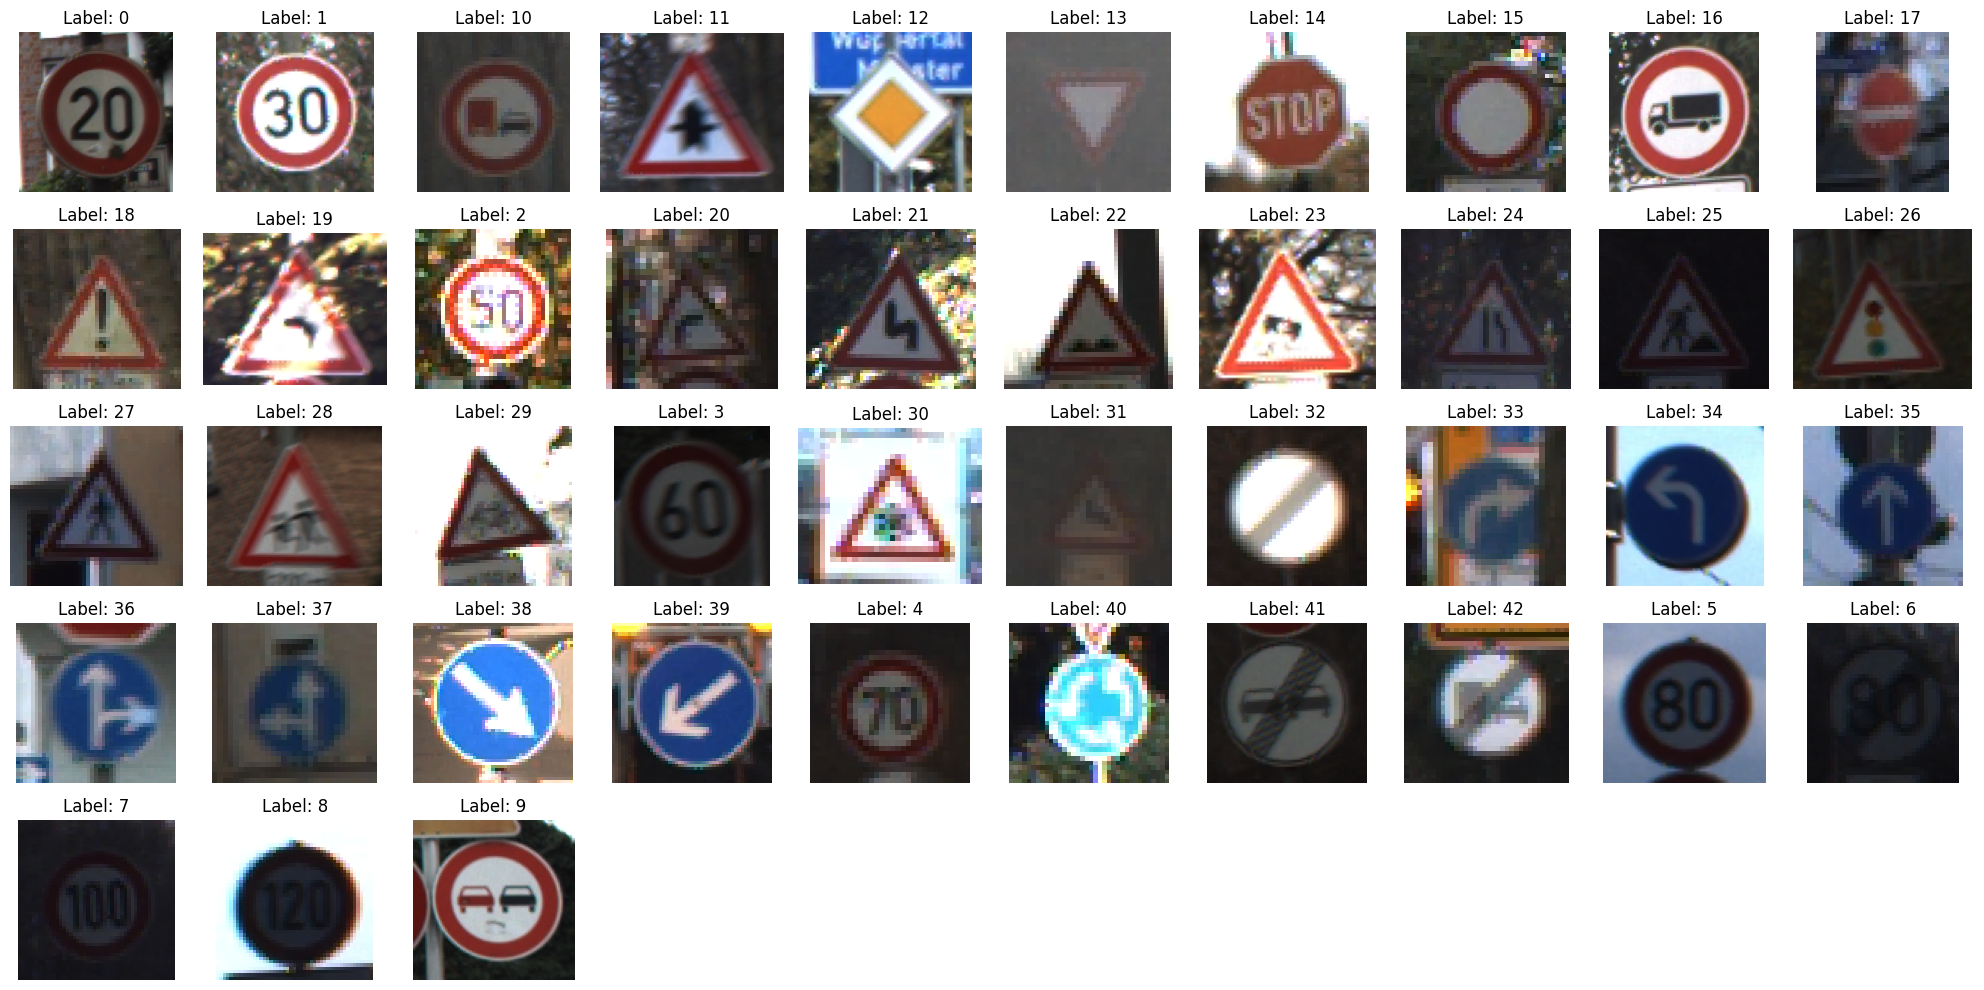

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path to the training dataset
train_dir = './data/Train'

# Get the list of class directories
class_dirs = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
num_classes = len(class_dirs)

# Initialize a dictionary to hold image paths grouped by labels
images_by_class = {label: [] for label in class_dirs}

# Iterate through the training directory
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith('.png'):
            label = os.path.basename(root)
            if label in images_by_class:
                images_by_class[label].append(os.path.join(root, file))

# Display basic information about the dataset
num_images = sum(len(images) for images in images_by_class.values())
print(f"Number of images: {num_images}")
print(f"Number of classes: {num_classes}")

# Select one random image from each class
selected_images = [random.choice(images_by_class[label]) for label in class_dirs]

# Display the selected images
rows = (num_classes + 9) // 10  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, 10, figsize=(20, 2 * rows))

for i, img_path in enumerate(selected_images):
    row = i // 10
    col = i % 10
    img = mpimg.imread(img_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Label: {class_dirs[i]}")
    axes[row, col].axis('off')

# Hide any unused subplots
for j in range(i + 1, rows * 10):
    row = j // 10
    col = j % 10
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Total number of images: 39209


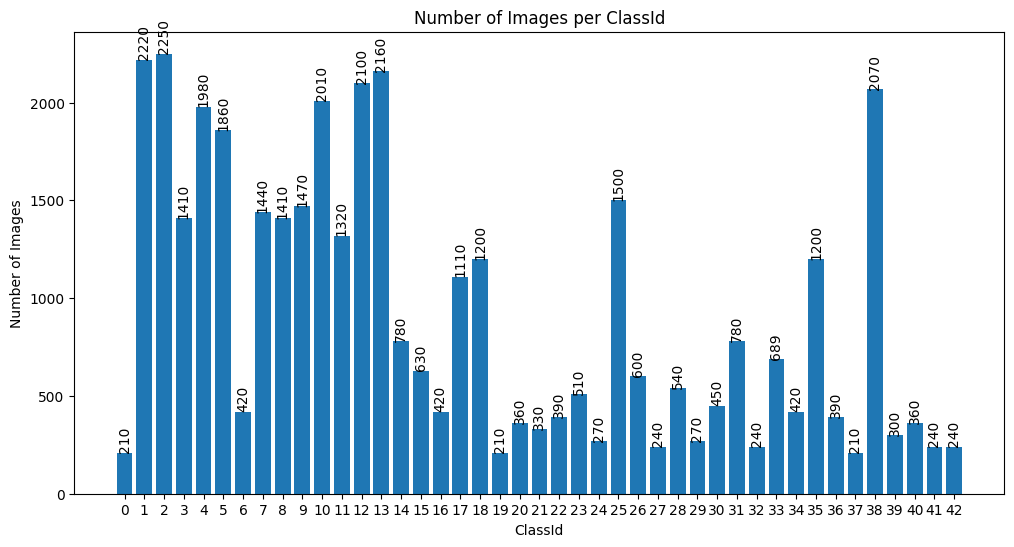

Maximum Width: 243
Maximum Height: 225


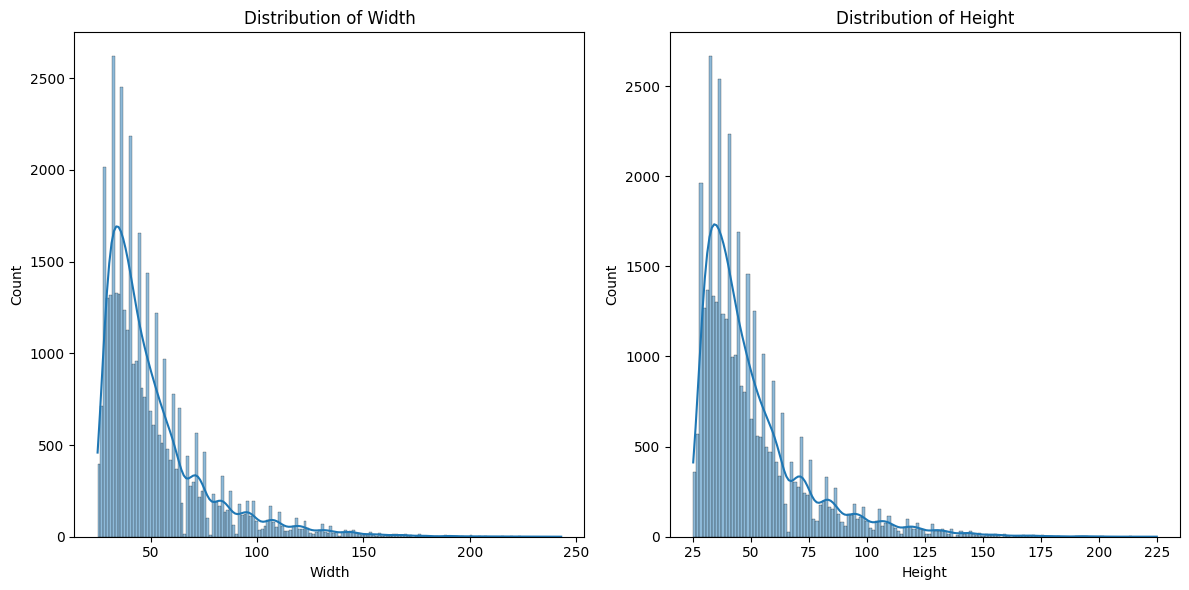

In [ ]:
import pandas as pd
import seaborn as sns

# Load the CSV file into a DataFrame
csv_path = './data/Train.csv'
df = pd.read_csv(csv_path)

# Count the total number of images
total_images = len(df)
print(f"Total number of images: {total_images}")

# Count the number of images for each ClassId
class_counts = df['ClassId'].value_counts().sort_index()

# Plot the number of images for each ClassId in a bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(class_counts.index, class_counts.values)
plt.xlabel('ClassId')
plt.ylabel('Number of Images')
plt.title('Number of Images per ClassId')

# Add the number of images on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', rotation=90)

# Show x-axis labels
plt.xticks(ticks=class_counts.index, labels=class_counts.index)
plt.show()

# Print the maximum Width and Height
max_width = df['Width'].max()
max_height = df['Height'].max()
print(f"Maximum Width: {max_width}")
print(f"Maximum Height: {max_height}")

# Show distribution plots for Width and Height
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Width'], kde=True)
plt.title('Distribution of Width')

plt.subplot(1, 2, 2)
sns.histplot(df['Height'], kde=True)
plt.title('Distribution of Height')

plt.tight_layout()
plt.show()

# Visualization of data augmentation

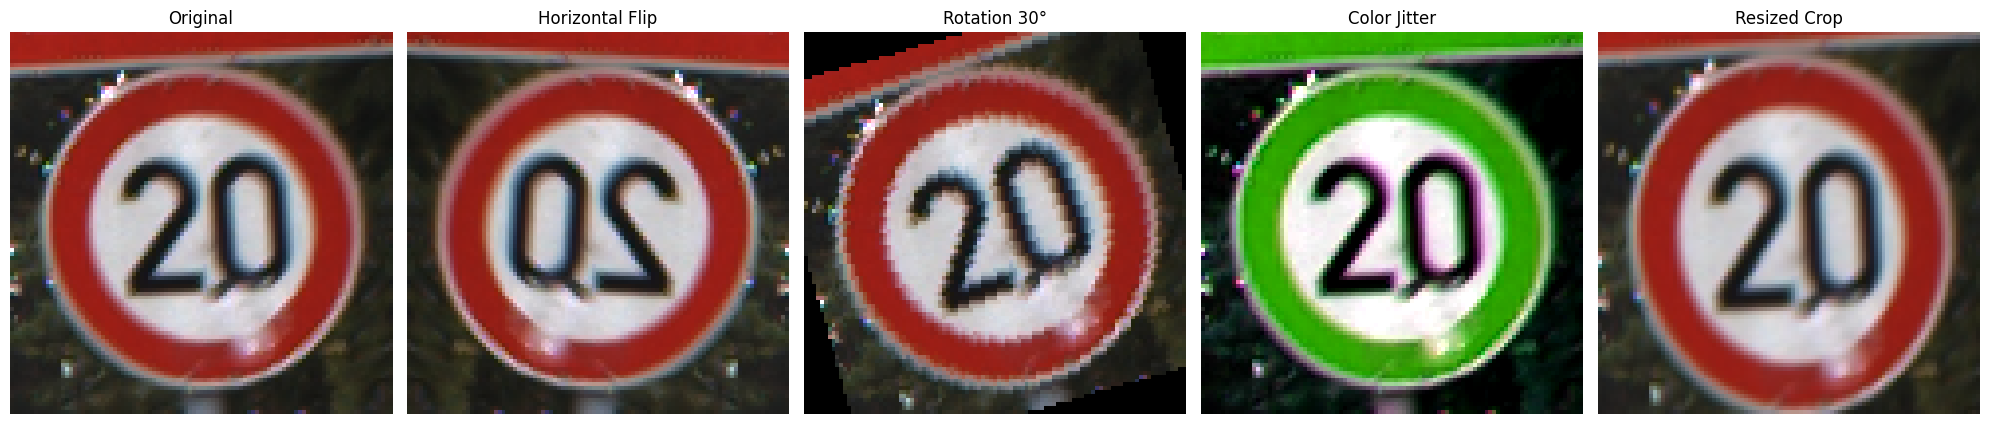

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import torchvision.transforms as transforms

# Load the CSV file into a DataFrame
csv_path = './data/Train.csv'
df = pd.read_csv(csv_path)
# Filter images for a specific class (e.g., ClassId = 0)
class_id = 0
class_images = ['./data/'+ im_path for im_path in df[df['ClassId'] == class_id]['Path'].tolist()]

# Select a random image from the filtered images
random_image_path = random.choice(class_images)
image = Image.open(random_image_path)

# Define individual data augmentation techniques
transformations = [
    ("Original", None),
    ("Horizontal Flip", transforms.RandomHorizontalFlip(p=1)),
    ("Rotation 30°", transforms.RandomRotation(30)),
    ("Color Jitter", transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)),
    ("Resized Crop", transforms.RandomResizedCrop(size=(image.size[1], image.size[0]), scale=(0.8, 1.0)))
]

# Apply transformations
augmented_images = [(name, transform(image) if transform else image) for name, transform in transformations]

# Display the original and augmented images
fig, axes = plt.subplots(1, len(augmented_images), figsize=(20, 5))

# Show original and augmented images with titles
for i, (name, aug_img) in enumerate(augmented_images):
    axes[i].imshow(aug_img)
    axes[i].set_title(name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# CNN modeling

In [ ]:
import os
import time
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

class GTSRBDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 7]) # Path is in column 7
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx, 6] # ClassId is in column 6

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the path to the training dataset
train_dir = './data/Train'
test_dir = './data/Test'
model_dir = './model'
os.makedirs(model_dir, exist_ok=True)

# Define image size and batch size
image_size = (32, 32)
batch_size = 16
num_epochs = 10
validation_split = 0.2

# Define data augmentation and normalization transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = GTSRBDataset('./data/Train.csv', './data', transform=transform)
test_dataset = GTSRBDataset('./data/Test.csv', './data', transform=transform_eval)


# Check if the image files exist
for idx in range(5):  # Check first 5 samples
    img_path = os.path.join(train_dataset.root_dir, train_dataset.data.iloc[idx, 7])
    print(f"Checking image path: {img_path}, Exists: {os.path.exists(img_path)}")

# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



Number of training samples: 39209
Number of test samples: 12630
Checking image path: ./data\Train/20/00020_00000_00000.png, Exists: True
Checking image path: ./data\Train/20/00020_00000_00001.png, Exists: True
Checking image path: ./data\Train/20/00020_00000_00002.png, Exists: True
Checking image path: ./data\Train/20/00020_00000_00003.png, Exists: True
Checking image path: ./data\Train/20/00020_00000_00004.png, Exists: True
Number of batches in train_loader: 1961
Number of batches in val_loader: 491
Number of batches in test_loader: 790


In [ ]:
num_classes = 43

In [ ]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.bn5 = nn.BatchNorm2d(128)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 1 * 1, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

# Initialize the model, loss function, optimizer, and learning rate scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = CNNModel(num_classes=num_classes).to(device)
summary(model, input_size=(3, 32, 32))

device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           9,248
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
       BatchNorm2d-8             [-1, 64, 8, 8]             128
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]          36,928
      BatchNorm2d-11             [-1, 64, 4, 4]             128
        MaxPool2d-12             [-1, 64, 2, 2]               0
           Conv2d-13            [-1, 128, 2, 2]          73,856
      BatchNorm2d-14      

In [ ]:
model

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=128, out_f

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Training and validation logs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # Save model checkpoint
    torch.save(model.state_dict(), os.path.join(model_dir, f"model_epoch_{epoch+1}.pth"))
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break
    
    # Step the learning rate scheduler
    scheduler.step()

end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Save loss and accuracy logs for later analysis
np.save(os.path.join(model_dir, "train_losses.npy"), np.array(train_losses))
np.save(os.path.join(model_dir, "val_losses.npy"), np.array(val_losses))
np.save(os.path.join(model_dir, "train_accuracies.npy"), np.array(train_accuracies))
np.save(os.path.join(model_dir, "val_accuracies.npy"), np.array(val_accuracies))

Epoch 1/10 [Validation]: 100%|██████████| 491/491 [00:07<00:00, 61.43it/s]


Epoch 1/10, Train Loss: 1.0904, Train Accuracy: 0.6756, Val Loss: 0.1740, Val Accuracy: 0.9482


Epoch 2/10 [Validation]: 100%|██████████| 491/491 [00:08<00:00, 59.28it/s]


Epoch 2/10, Train Loss: 0.2227, Train Accuracy: 0.9323, Val Loss: 0.0847, Val Accuracy: 0.9703


Epoch 3/10 [Validation]: 100%|██████████| 491/491 [00:08<00:00, 59.68it/s]


Epoch 3/10, Train Loss: 0.1462, Train Accuracy: 0.9561, Val Loss: 0.0439, Val Accuracy: 0.9871


Epoch 4/10 [Validation]: 100%|██████████| 491/491 [00:08<00:00, 58.80it/s]


Epoch 4/10, Train Loss: 0.1025, Train Accuracy: 0.9681, Val Loss: 0.0671, Val Accuracy: 0.9792


Epoch 5/10 [Validation]: 100%|██████████| 491/491 [00:08<00:00, 59.05it/s]


Epoch 5/10, Train Loss: 0.0911, Train Accuracy: 0.9735, Val Loss: 0.0528, Val Accuracy: 0.9852


Epoch 6/10 [Validation]: 100%|██████████| 491/491 [00:08<00:00, 55.97it/s]


Epoch 6/10, Train Loss: 0.0315, Train Accuracy: 0.9908, Val Loss: 0.0165, Val Accuracy: 0.9963


Epoch 7/10 [Validation]: 100%|██████████| 491/491 [00:08<00:00, 59.92it/s]


Epoch 7/10, Train Loss: 0.0152, Train Accuracy: 0.9956, Val Loss: 0.0148, Val Accuracy: 0.9963


Epoch 8/10 [Validation]: 100%|██████████| 491/491 [00:08<00:00, 58.95it/s]


Epoch 8/10, Train Loss: 0.0126, Train Accuracy: 0.9963, Val Loss: 0.0128, Val Accuracy: 0.9966


Epoch 9/10 [Validation]: 100%|██████████| 491/491 [00:08<00:00, 58.31it/s]


Epoch 9/10, Train Loss: 0.0107, Train Accuracy: 0.9966, Val Loss: 0.0136, Val Accuracy: 0.9960


Epoch 10/10 [Validation]: 100%|██████████| 491/491 [00:08<00:00, 55.68it/s]

Epoch 10/10, Train Loss: 0.0090, Train Accuracy: 0.9975, Val Loss: 0.0116, Val Accuracy: 0.9968
Training completed in 483.71 seconds


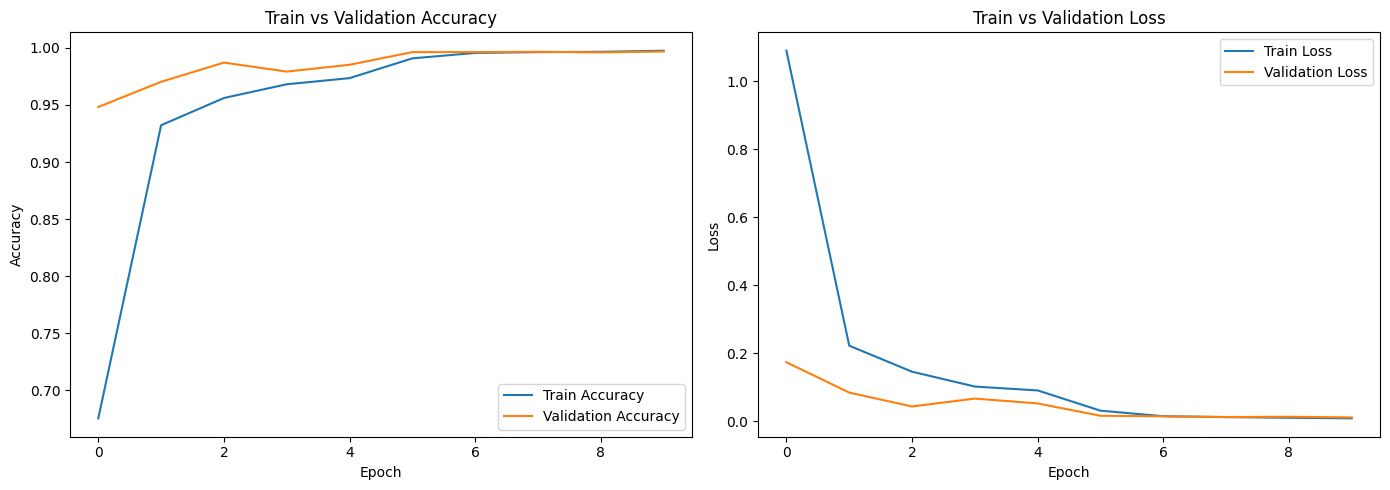

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load the saved logs
train_losses = np.load(os.path.join(model_dir, "train_losses.npy"))
val_losses = np.load(os.path.join(model_dir, "val_losses.npy"))
train_accuracies = np.load(os.path.join(model_dir, "train_accuracies.npy"))
val_accuracies = np.load(os.path.join(model_dir, "val_accuracies.npy"))

# Plot training vs. validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(train_accuracies, label='Train Accuracy')
ax1.plot(val_accuracies, label='Validation Accuracy')
ax1.set_title('Train vs Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(train_losses, label='Train Loss')
ax2.plot(val_losses, label='Validation Loss')
ax2.set_title('Train vs Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
def extract_epoch(filename):
    # Assuming the filename format is 'model_epoch_<number>.pth'
    base = os.path.basename(filename)
    epoch_str = base.split('_')[-1].split('.')[0]
    return int(epoch_str)

model_files = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if f.endswith('.pth')]
latest_model_path = sorted(model_files, key=extract_epoch)[-1]
latest_model_path

'./model_simpleCNN_without_aug_batch16\\model_epoch_10.pth'

C:\Users\easyb\AppData\Local\Temp\ipykernel_26324\2876657943.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(latest_model_path))
Infere

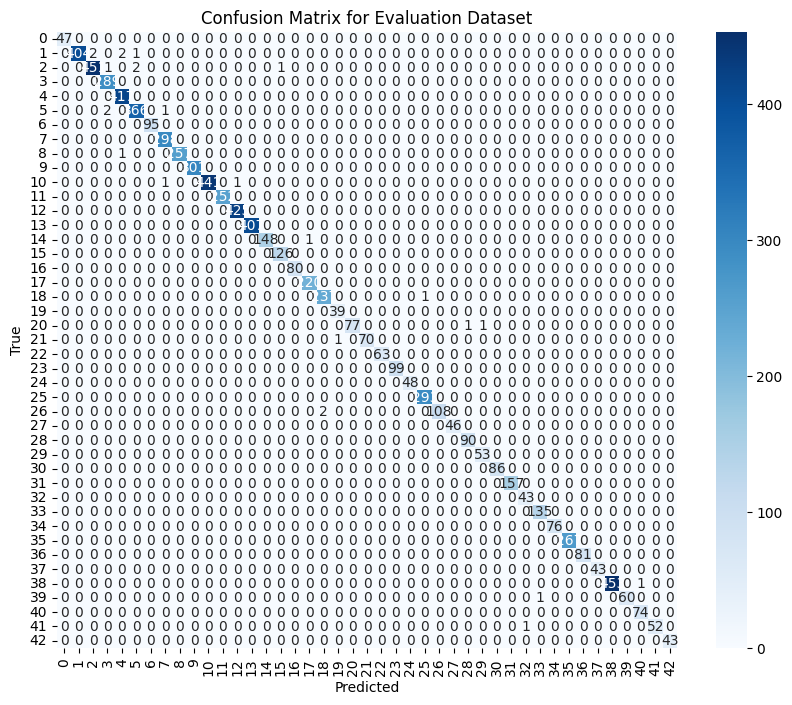

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      0.99      0.99       409
           2       1.00      0.99      0.99       455
           3       0.99      1.00      0.99       289
           4       0.99      1.00      1.00       417
           5       0.99      0.99      0.99       369
           6       1.00      1.00      1.00        95
           7       0.99      1.00      1.00       298
           8       1.00      1.00      1.00       258
           9       1.00      1.00      1.00       301
          10       1.00      1.00      1.00       443
          11       1.00      1.00      1.00       252
          12       1.00      1.00      1.00       425
          13       1.00      1.00      1.00       407
          14       1.00      0.99      1.00       149
          15       0.99      1.00      1.00       126
          16       1.00      1.00      1.00        80
    

In [ ]:
import os
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the latest model checkpoint
model_files = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if f.endswith('.pth')]
latest_model_path = sorted(model_files, key=extract_epoch)[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=43).to(device)
model.load_state_dict(torch.load(latest_model_path))
model.eval()

# Perform inference on the validation dataset
y_true = []
y_pred = []

for images, labels in tqdm(val_loader, desc="Inference"):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Evaluation Dataset')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
class_report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(43)])
print('Classification Report:')
print(class_report)

Inference: 100%|██████████| 790/790 [00:13<00:00, 59.40it/s]


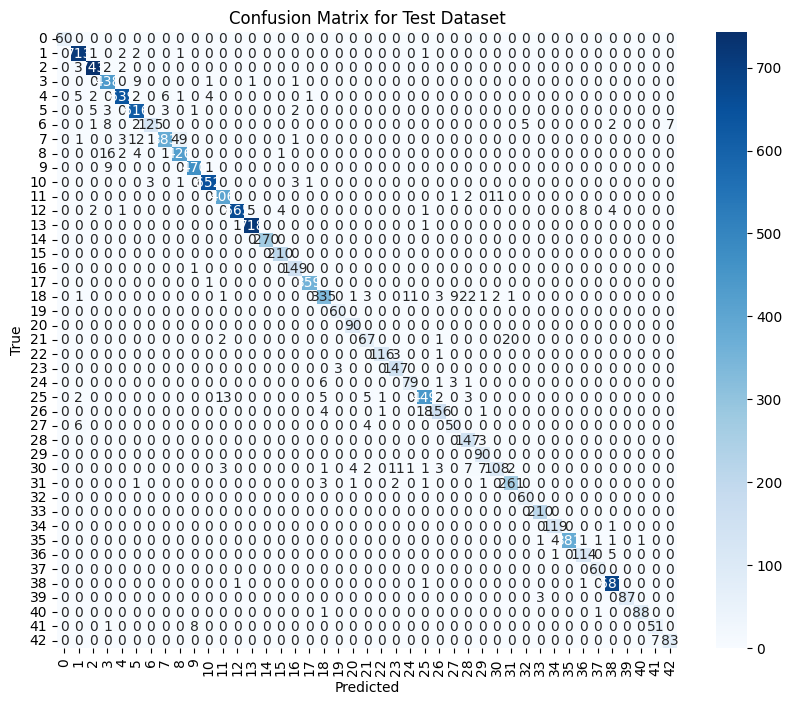

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.98      0.99      0.98       720
           2       0.99      0.99      0.99       750
           3       0.92      0.97      0.94       450
           4       0.98      0.97      0.98       660
           5       0.95      0.98      0.96       630
           6       0.97      0.83      0.90       150
           7       0.97      0.85      0.91       450
           8       0.89      0.95      0.92       450
           9       0.98      0.98      0.98       480
          10       0.99      0.99      0.99       660
          11       0.96      0.97      0.96       420
          12       1.00      0.96      0.98       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99       210
          16       0.96      0.99      0.97       150
    

In [ ]:
# Perform inference on the validation dataset
y_true = []
y_pred = []

for images, labels in tqdm(test_loader, desc="Inference"):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Test Dataset')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
class_report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(43)])
print('Classification Report:')
print(class_report)

Inference: 100%|██████████| 12630/12630 [00:33<00:00, 372.17it/s]


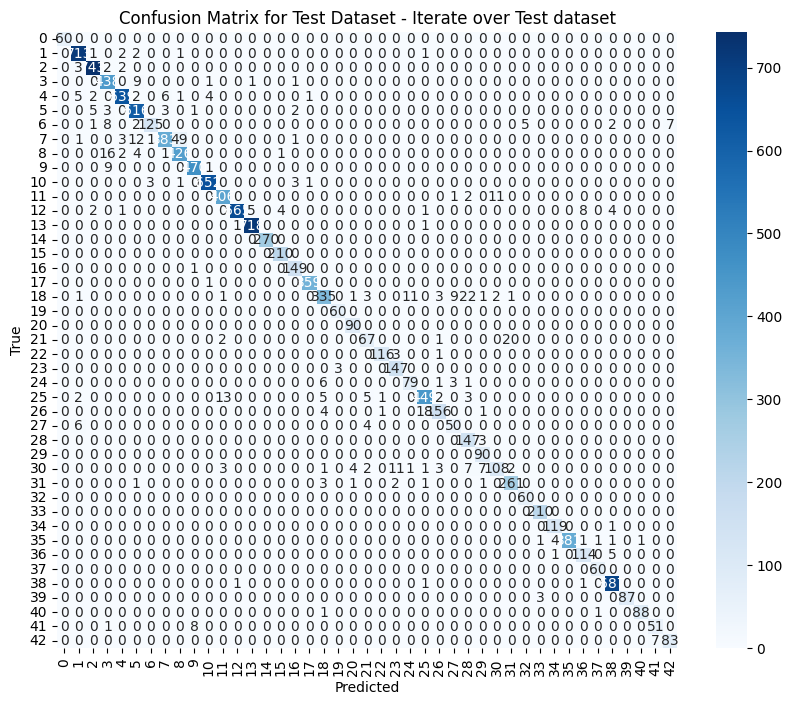

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.98      0.99      0.98       720
           2       0.99      0.99      0.99       750
           3       0.92      0.97      0.94       450
           4       0.98      0.97      0.98       660
           5       0.95      0.98      0.96       630
           6       0.97      0.83      0.90       150
           7       0.97      0.85      0.91       450
           8       0.89      0.95      0.92       450
           9       0.98      0.98      0.98       480
          10       0.99      0.99      0.99       660
          11       0.96      0.97      0.96       420
          12       1.00      0.96      0.98       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99       210
          16       0.96      0.99      0.97       150
    

In [ ]:
# Define the path to the test dataset and CSV file
data_dir = './data'
test_csv_path = './data/Test.csv'



# Load the test CSV file
test_df = pd.read_csv(test_csv_path)

# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform_eval(image)
    return image

# Perform inference on the test dataset
y_true = []
y_pred = []
incorrect_indices = []

for index, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Inference"):
    image_path = os.path.join(data_dir, row['Path'])
    image = load_image(image_path).unsqueeze(0).to(device)
    label = row['ClassId']
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    y_true.append(label)
    y_pred.append(predicted.item())

    if predicted.item() != label:
        incorrect_indices.append(index)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Test Dataset - Iterate over Test dataset')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
class_report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(43)])
print('Classification Report:')
print(class_report)

In [ ]:
# Define the label dictionary
classes = { 
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)', 
    2: 'Speed limit (50km/h)', 
    3: 'Speed limit (60km/h)', 
    4: 'Speed limit (70km/h)', 
    5: 'Speed limit (80km/h)', 
    6: 'End of speed limit (80km/h)', 
    7: 'Speed limit (100km/h)', 
    8: 'Speed limit (120km/h)', 
    9: 'No passing', 
    10: 'No passing veh over 3.5 tons', 
    11: 'Right-of-way at intersection', 
    12: 'Priority road', 
    13: 'Yield', 
    14: 'Stop', 
    15: 'No vehicles', 
    16: 'Veh > 3.5 tons prohibited', 
    17: 'No entry', 
    18: 'General caution', 
    19: 'Dangerous curve left', 
    20: 'Dangerous curve right', 
    21: 'Double curve', 
    22: 'Bumpy road', 
    23: 'Slippery road', 
    24: 'Road narrows on the right', 
    25: 'Road work', 
    26: 'Traffic signals', 
    27: 'Pedestrians', 
    28: 'Children crossing', 
    29: 'Bicycles crossing', 
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing', 
    32: 'End speed + passing limits', 
    33: 'Turn right ahead', 
    34: 'Turn left ahead', 
    35: 'Ahead only', 
    36: 'Go straight or right', 
    37: 'Go straight or left', 
    38: 'Keep right', 
    39: 'Keep left', 
    40: 'Roundabout mandatory', 
    41: 'End of no passing', 
    42: 'End no passing veh > 3.5 tons' 
}

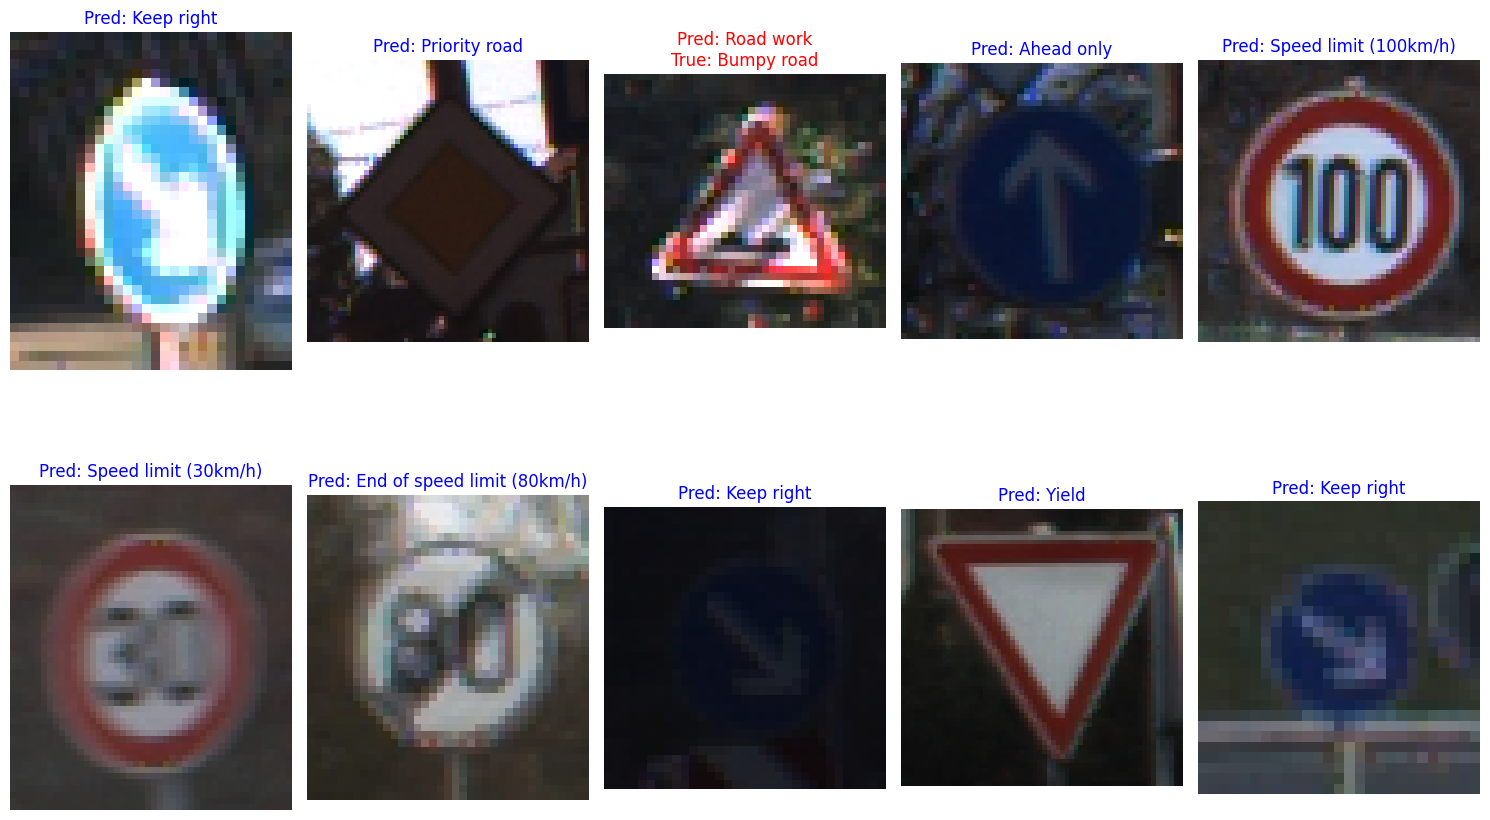

In [ ]:
# Select 10 random images from test_df
sampled_df = test_df.sample(n=10)

# Plot the images
fig, axes = plt.subplots(2, 5, figsize=(15, 10))
axes = axes.flatten()

for i, (index, row) in enumerate(sampled_df.iterrows()):
    img_path = os.path.join(data_dir, row['Path'])
    true_label = row['ClassId']
    
    # Load and transform the image
    image = Image.open(img_path).convert('RGB')
    image_tensor = transform_eval(image).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_label = torch.max(output, 1)
        predicted_label = predicted_label.item()
    
    # Plot the image
    axes[i].imshow(image)
    axes[i].axis('off')
    
    # Set the title color based on prediction correctness
    if predicted_label == true_label:
        title_color = 'blue'
        title_text = f"Pred: {classes[predicted_label]}"
    else:
        title_color = 'red'
        title_text = f"Pred: {classes[predicted_label]}\nTrue: {classes[true_label]}"
    
    axes[i].set_title(title_text, color=title_color)

plt.tight_layout()
plt.show()

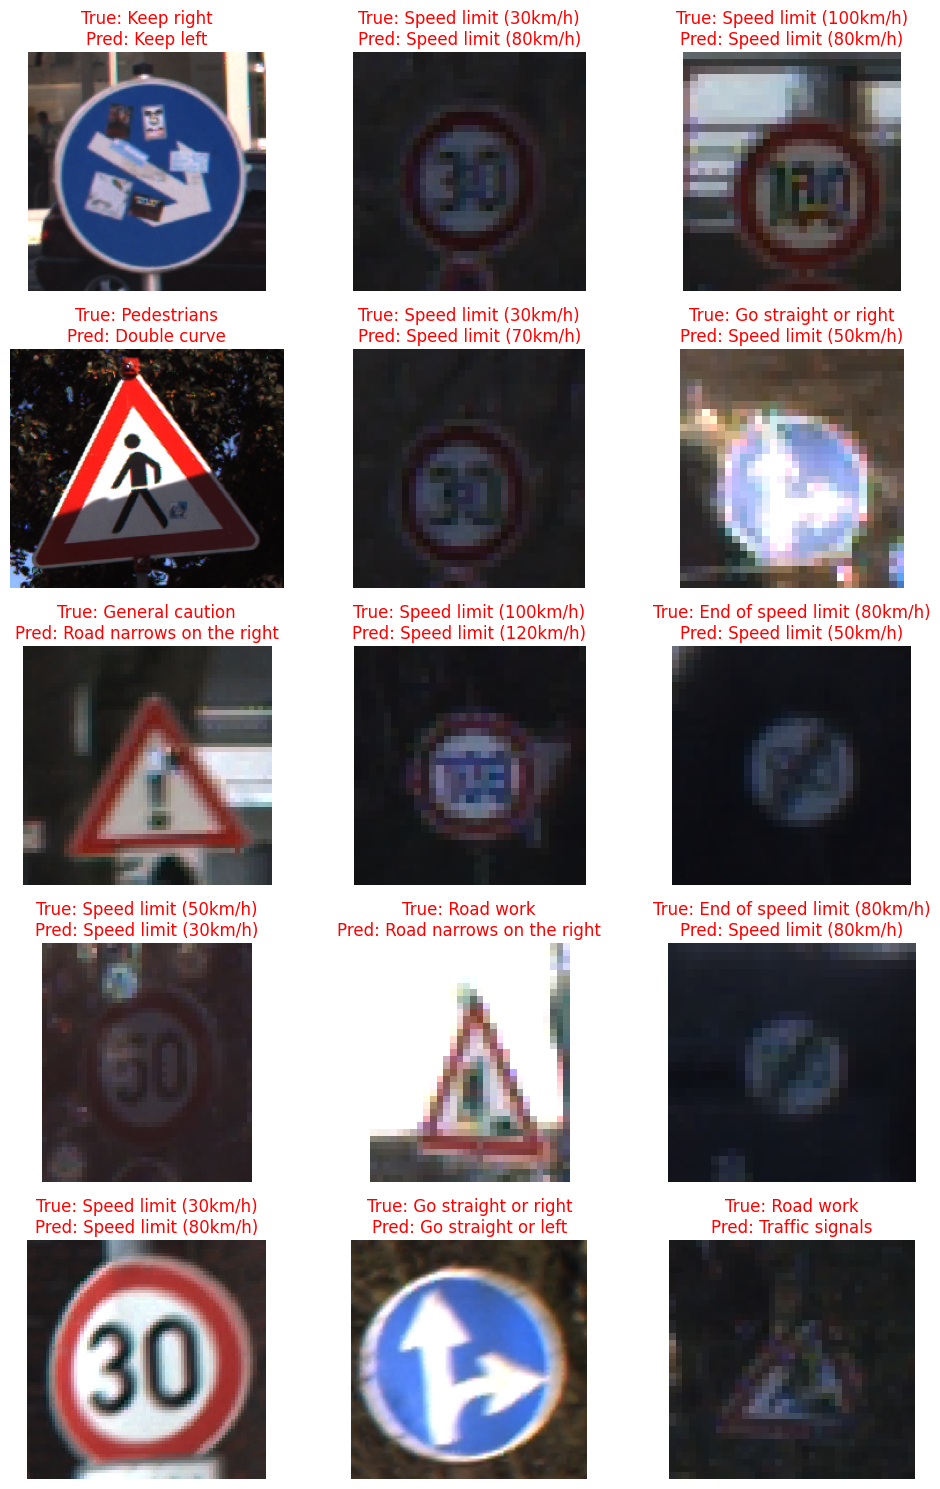

In [ ]:
import random
# Select 10 incorrect predictions
selected_indices = random.sample(incorrect_indices, 15)

# Plot the images with incorrect predictions
fig, axes = plt.subplots(5, 3, figsize=(10, 15))
axes = axes.flatten()

for i, idx in enumerate(selected_indices):
    row = test_df.iloc[idx]
    img_path = os.path.join(data_dir, row['Path'])
    true_label = row['ClassId']
    predicted_label = y_pred[idx]
    
    # Load and transform the image
    image = Image.open(img_path).convert('RGB')
    
    # Plot the image
    axes[i].imshow(image)
    axes[i].axis('off')
    
    # Set the title with ground truth and predicted labels
    title_text = f"True: {classes[true_label]}\nPred: {classes[predicted_label]}"
    axes[i].set_title(title_text, color='red')

plt.tight_layout()
plt.show()

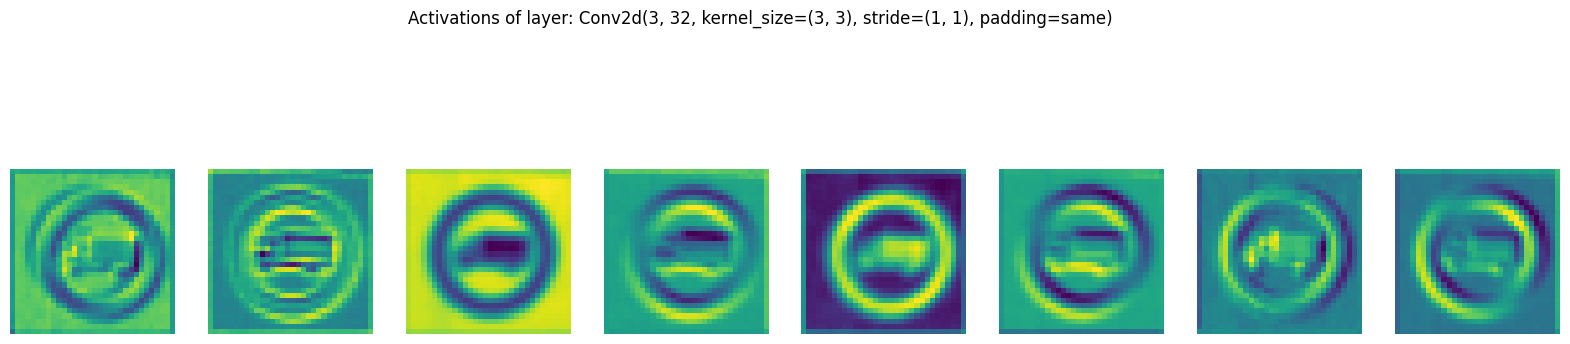

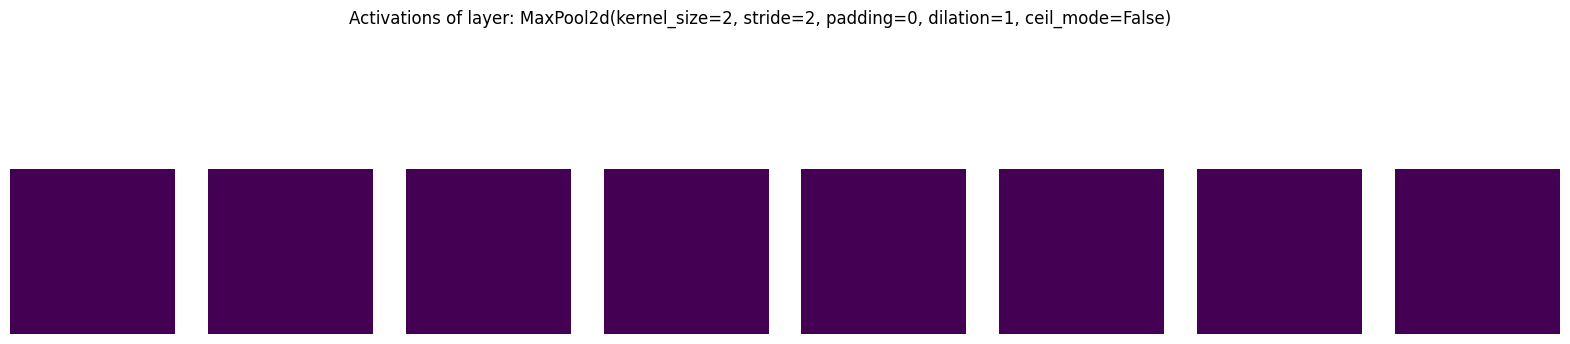

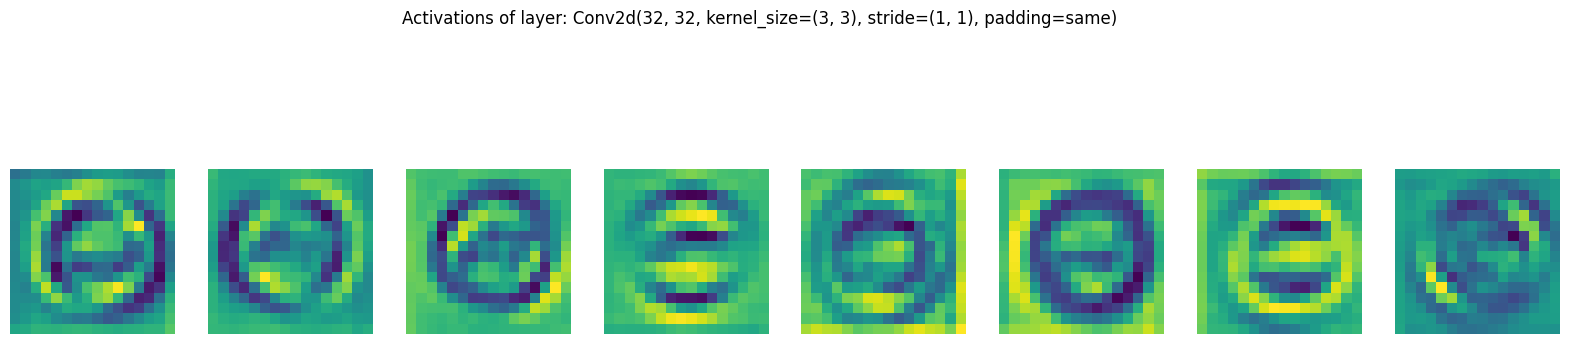

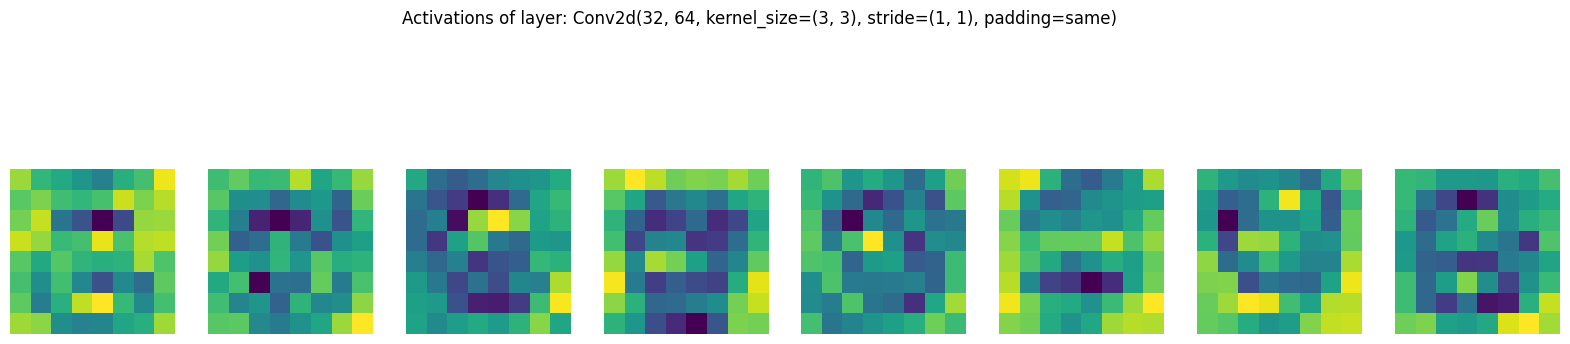

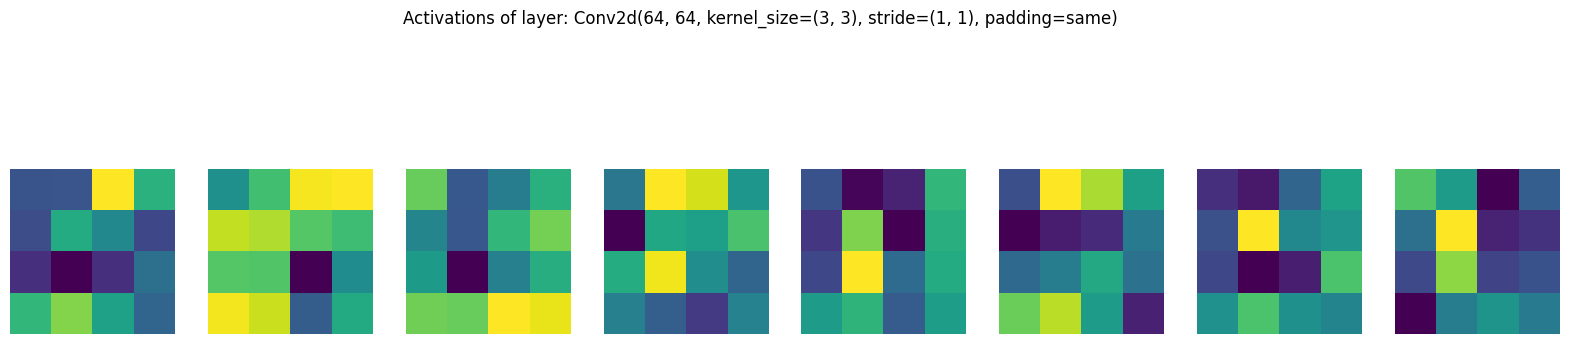

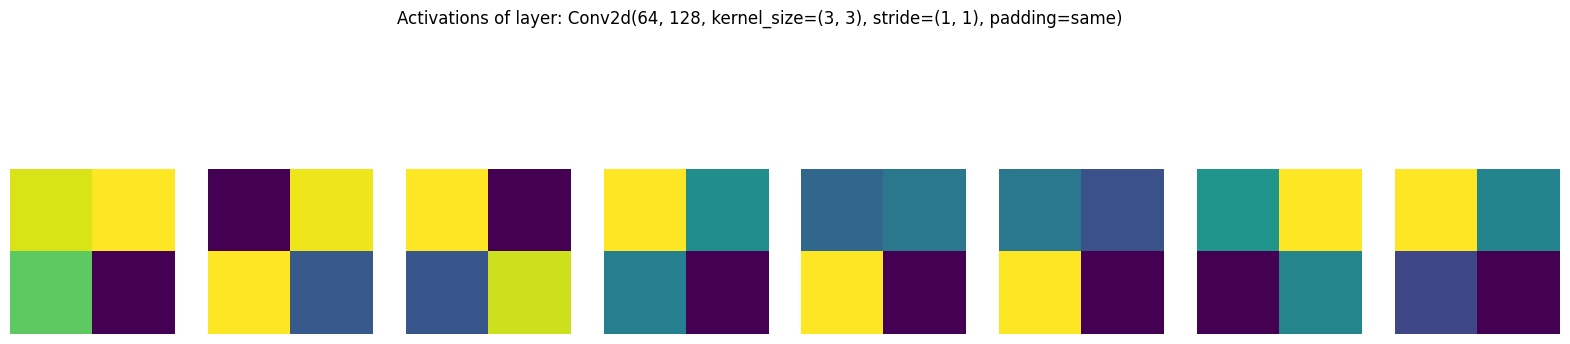

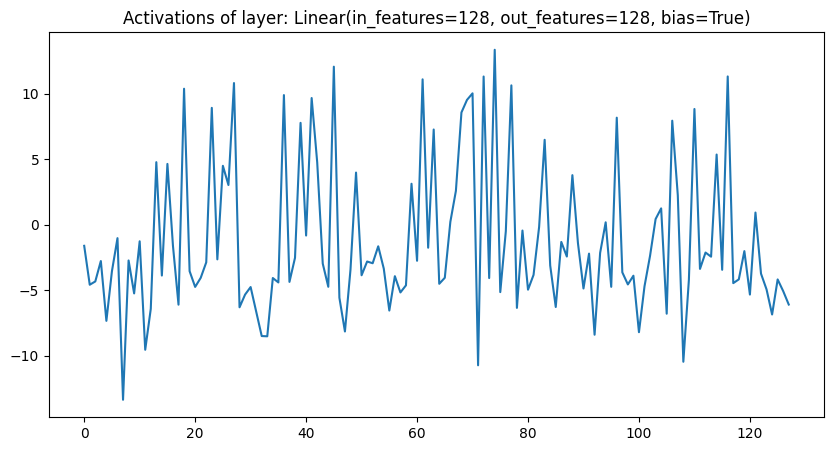

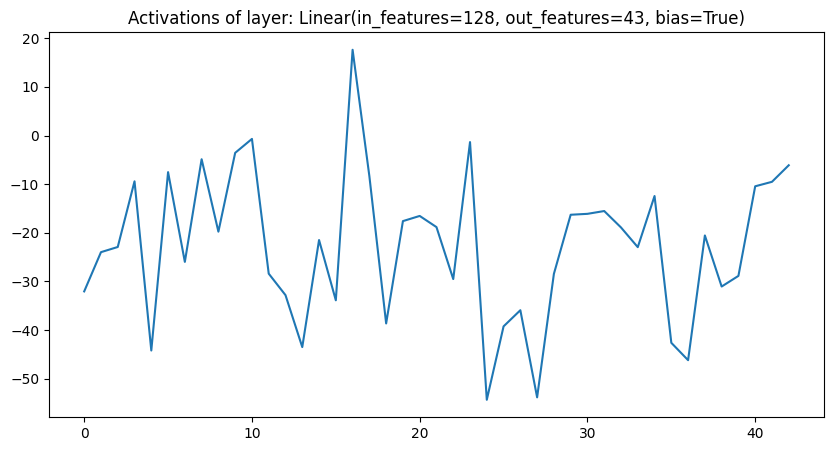

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


# Example test image path
test_image_path = './data/Test/00000.png'  # Replace with an actual test image path
image = load_image(test_image_path).unsqueeze(0).to(device)

# Define a hook function to capture activations
activations = {}

def hook_fn(module, input, output):
    activations[module] = output

# Register hooks to the layers of interest
for name, layer in model.named_modules():
    if isinstance(layer, (nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear)):
        layer.register_forward_hook(hook_fn)

# Perform a forward pass to capture the activations
model.eval()
with torch.no_grad():
    output = model(image)

# Function to visualize the activations
def visualize_activations(activations):
    for layer, activation in activations.items():
        if len(activation.shape) == 4:  # Conv2d or MaxPool2d layers
            num_filters = activation.shape[1]
            fig, axes = plt.subplots(1, min(num_filters, 8), figsize=(20, 5))
            for i in range(min(num_filters, 8)):
                axes[i].imshow(activation[0, i].cpu().numpy(), cmap='viridis')
                axes[i].axis('off')
            plt.suptitle(f'Activations of layer: {layer}')
            plt.show()
        elif len(activation.shape) == 2:  # Linear layers
            plt.figure(figsize=(10, 5))
            plt.plot(activation[0].cpu().numpy())
            plt.title(f'Activations of layer: {layer}')
            plt.show()

# Visualize the activations
visualize_activations(activations)

# For experimentation

## Simple CNN

In [ ]:
# Define the CNN model
class BaseCNNModel(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(BaseCNNModel, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')

        # Flatten layer to feed into fully connected layers
        self.flatten = nn.Flatten()

        # Fully connected layers (Input size changed based on feature map size after conv layers)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Adjust the input size here
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Forward pass through conv and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the tensor for fully connected layers
        x = self.flatten(x)

        # Forward pass through the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# Transfer learning with VGG

In [ ]:
# Define transfer learning model
class TransferLearningVGG(nn.Module):
    def __init__(self, num_classes=43):
        super(TransferLearningVGG, self).__init__()
        
        # Load the pre-trained VGG model
        self.vgg = models.vgg16_bn(pretrained=True)
        
        # Freeze the pre-trained layers
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        # Modify the classifier to match the number of classes
        self.vgg.classifier[6] = nn.Linear(4096, num_classes)
        
    def forward(self, x):
        x = self.vgg(x)
        return F.log_softmax(x, dim=1)